## Comparison and visualization of house prices in Beijing

### Step 1: Import Libraries; Obtain and Clean Data

In [2]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [4]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
#import descartes
#import folium

ModuleNotFoundError: No module named 'shapely'

In [5]:
# import data
df = pd.read_csv('1.BeijingHouse.csv')
df.head(3)

url            id  \
0  https://bj.lianjia.com/chengjiao/101084782030....  1.010000e+11   
1  https://bj.lianjia.com/chengjiao/101086012217....  1.010000e+11   
2  https://bj.lianjia.com/chengjiao/101086041636....  1.010000e+11   

          Lng        Lat           Cid   tradeTime   DOM  followers  \
0  116.475489  40.019520  1.110000e+12  2016-08-09  1464        106   
1  116.453917  39.881534  1.110000e+12  2016-07-28   903        126   
2  116.561978  39.877145  1.110000e+12  2016-12-11  1271         48   

   totalPrice  price  ...  kitchen  bathRoom  buildingType  constructionTime  \
0       415.0  31680  ...        1         1           1.0              2005   
1       575.0  43436  ...        1         2           1.0              2004   
2      1030.0  52021  ...        1         3           4.0              2005   

   renovationCondition  buildingStructure ladderRatio  elevator  \
0                    3                  6       0.217         1   
1                    4                  6       0.667         1   
2                    3                  6       0.500         1   

   fiveYearsProperty  subway  
0                  0       1  
1                  1       0  
2                  0       0  

[3 rows x 23 columns]

In [3]:
df.shape

(10629, 23)

In [4]:
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway'],
      dtype='object')

In [5]:
df.dtypes

url                     object
id                     float64
Lng                    float64
Lat                    float64
Cid                    float64
tradeTime               object
DOM                      int64
followers                int64
totalPrice             float64
price                    int64
square                 float64
livingRoom               int64
drawingRoom              int64
kitchen                  int64
bathRoom                 int64
buildingType           float64
constructionTime        object
renovationCondition      int64
buildingStructure        int64
ladderRatio            float64
elevator                 int64
fiveYearsProperty        int64
subway                   int64
dtype: object

- `price`: the average price by square
- `totalPrice`: the total price

### Step 2: Exploratory Data Analysis (EDA)

In [310]:
sns.set_palette('Greys_r')
sns.set_style('whitegrid')
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [6]:
full_corr_matrix = df.corr()[
    ['Lng', 'Lat', 'Cid', 'DOM', 'followers',
     'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
     'bathRoom', 'buildingType', 'renovationCondition', 'buildingStructure', 
     'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway']]

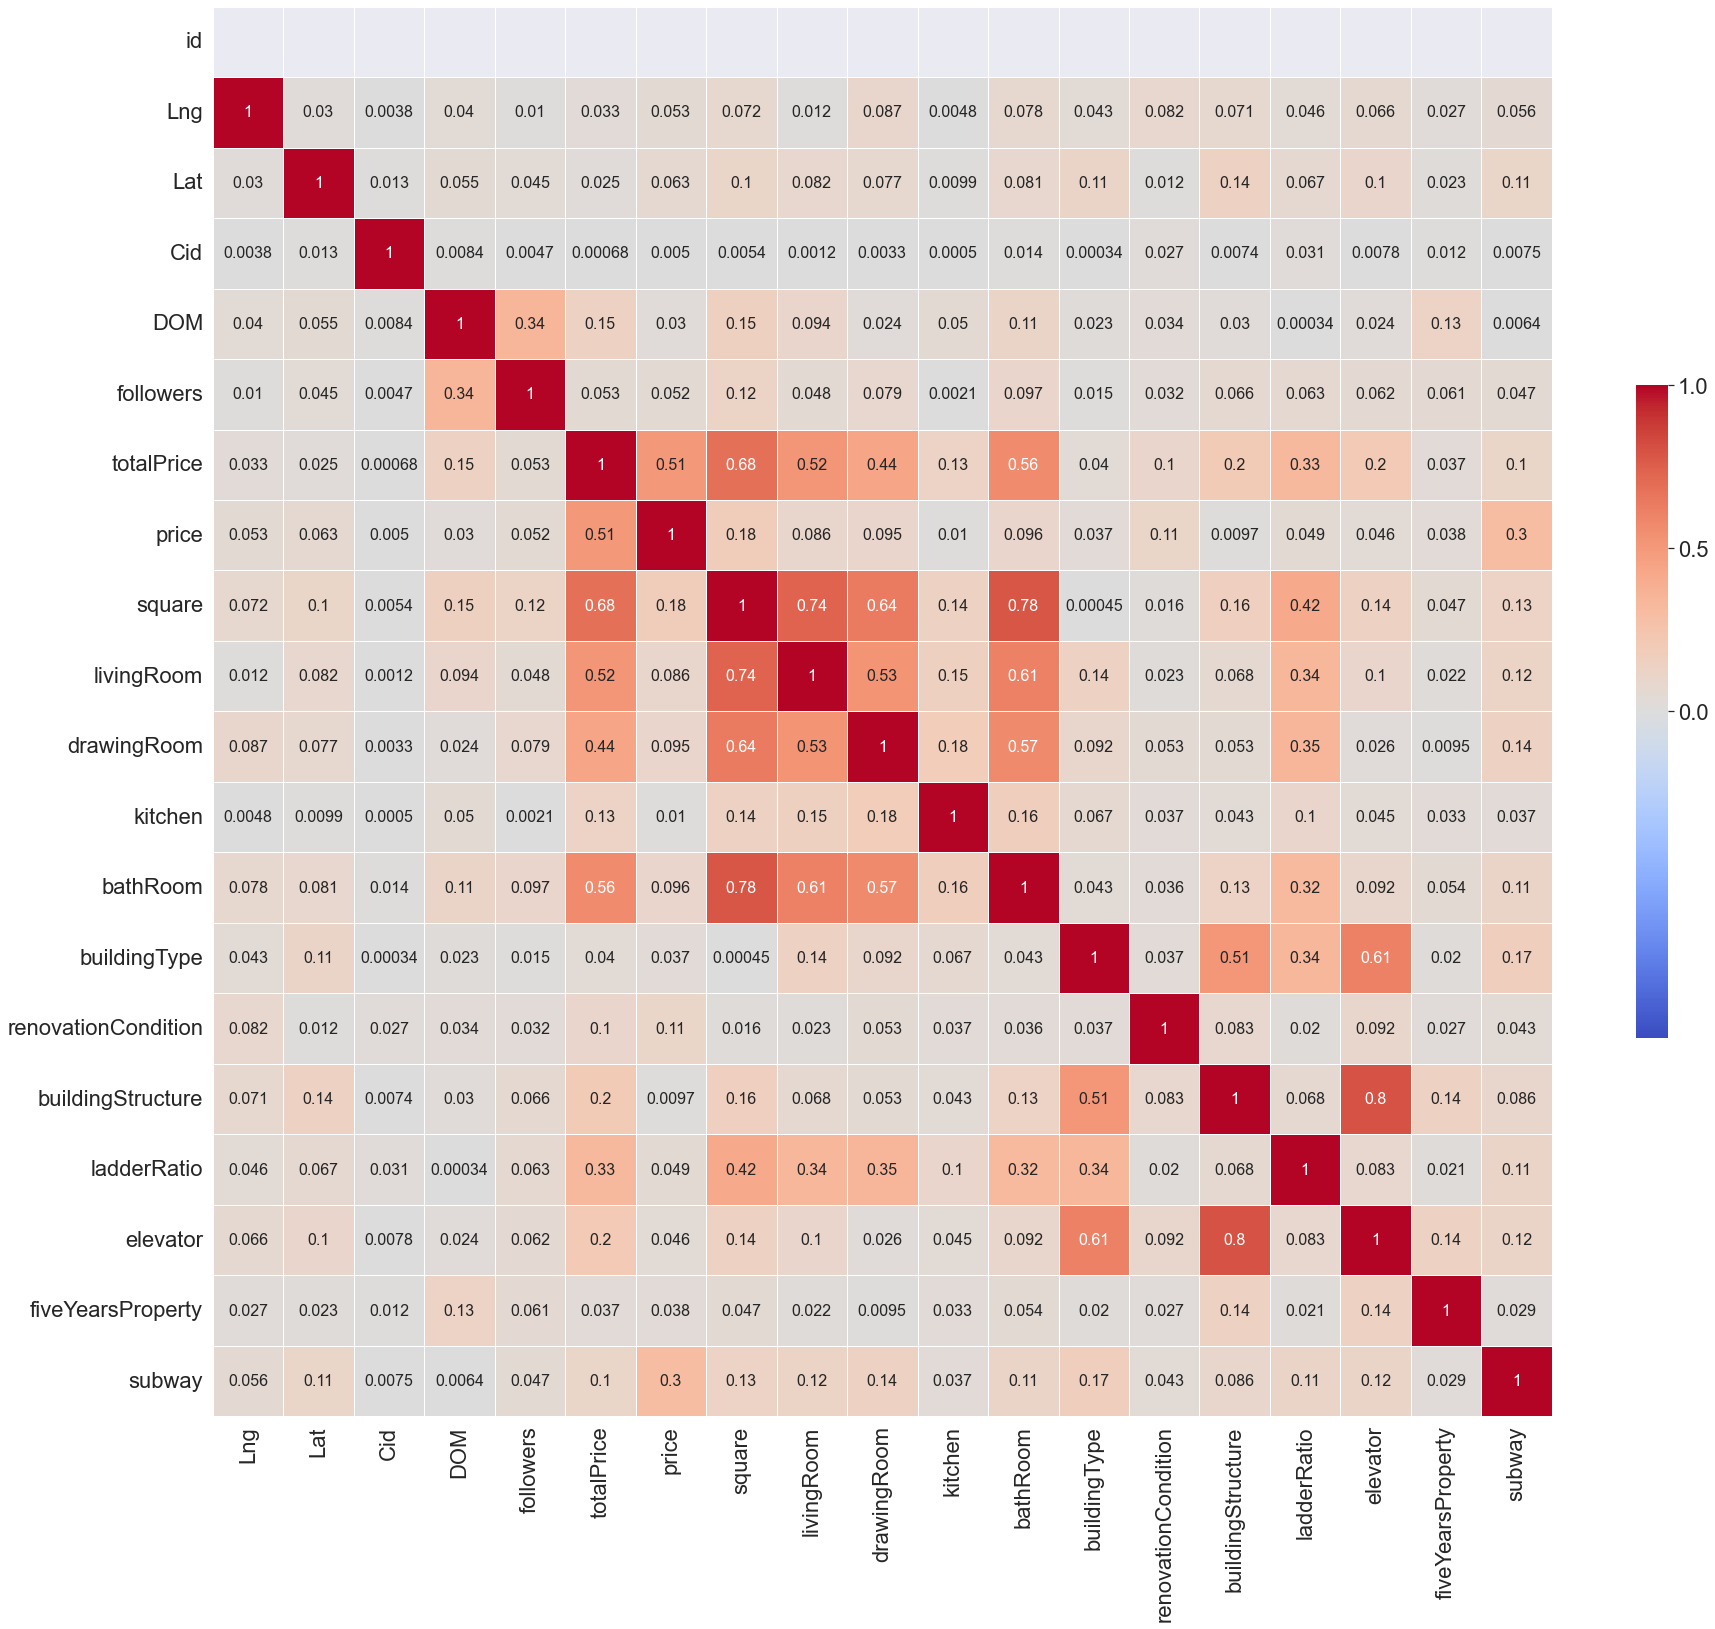

In [9]:
f, ax = plt.subplots(figsize=(30, 30))
columns = ['Lng', 'Lat', 'Cid', 'DOM', 'followers', 'totalPrice', 'price',
       'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom',
       'buildingType', 'renovationCondition', 'buildingStructure',
       'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway']

heatmap = sns.heatmap(abs(full_corr_matrix),
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                #'ticks' : [-1, -.5, 0, 0.5, 1]},
                                  'ticks' : [0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 16})

#add the column names as labels
ax.set_yticklabels(['id']+columns, rotation = 0)
ax.set_xticklabels(full_corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
sns.set(font_scale=2)

#plt.savefig('full_corr_matrix_abs.png')

This correlation matrix heatmap is a visual representation of how each variable is correlated. For our purposes, we can focus on looking at different variables correlation with `totalPrice`.

In [9]:
corr_matrix = df.corr()[['totalPrice']].sort_values('totalPrice')
corr_target = abs(corr_matrix)

In [10]:
salient_num_features = corr_target.loc[corr_target['totalPrice'] > 0.5, :]
salient_num_features

totalPrice
price         0.506238
livingRoom    0.515816
bathRoom      0.563007
square        0.680122
totalPrice    1.000000

This means that `price`, `livingRoom`, `bathRoom`, `square` are the variables with higher correlation (`>0.5`) with `totalPrice`.

In [11]:
corr_target2 = abs(df.corr()[['price']].sort_values('price'))
corr_target2.loc[corr_target2['price']>0.5]

price
totalPrice  0.506238
price       1.000000

Just as a cofirmation, we can see that `totalPrice` is a better metric than `price` (average price by square) for understanding correlation.

**After discussions we still think `price` should be more suitable as the dependent variable, and the reason why we are not seeing correlation immediately is probably because the features have not been engineered.**

Should we use `price`, `log(price)`, or `quad(price)`?

In [12]:
sns.set_palette('Greys_r')
sns.set_style('whitegrid')

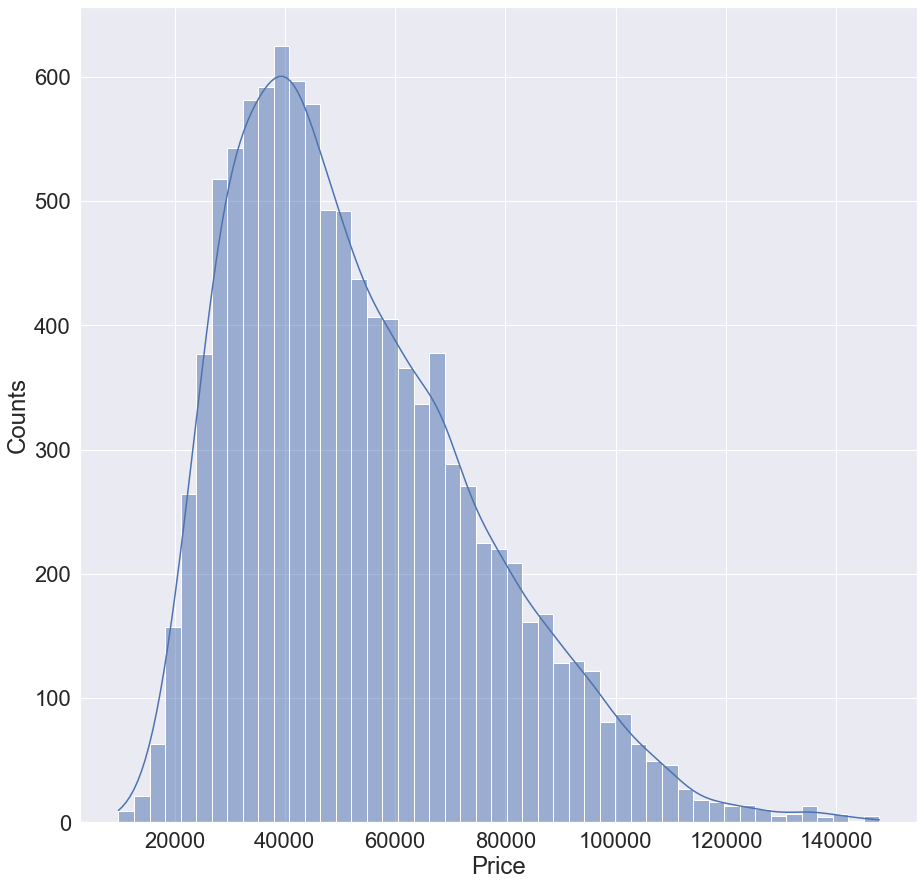

In [10]:
plt.figure(figsize=(15,15))
#plt.hist(df['price'])
sns.histplot(data=df, x='price', kde=True)
plt.xlabel('Price')
plt.ylabel('Counts')
#plt.savefig('price_hist.png')
plt.show()

In [11]:
df['price_log'] = np.log(df['price'])

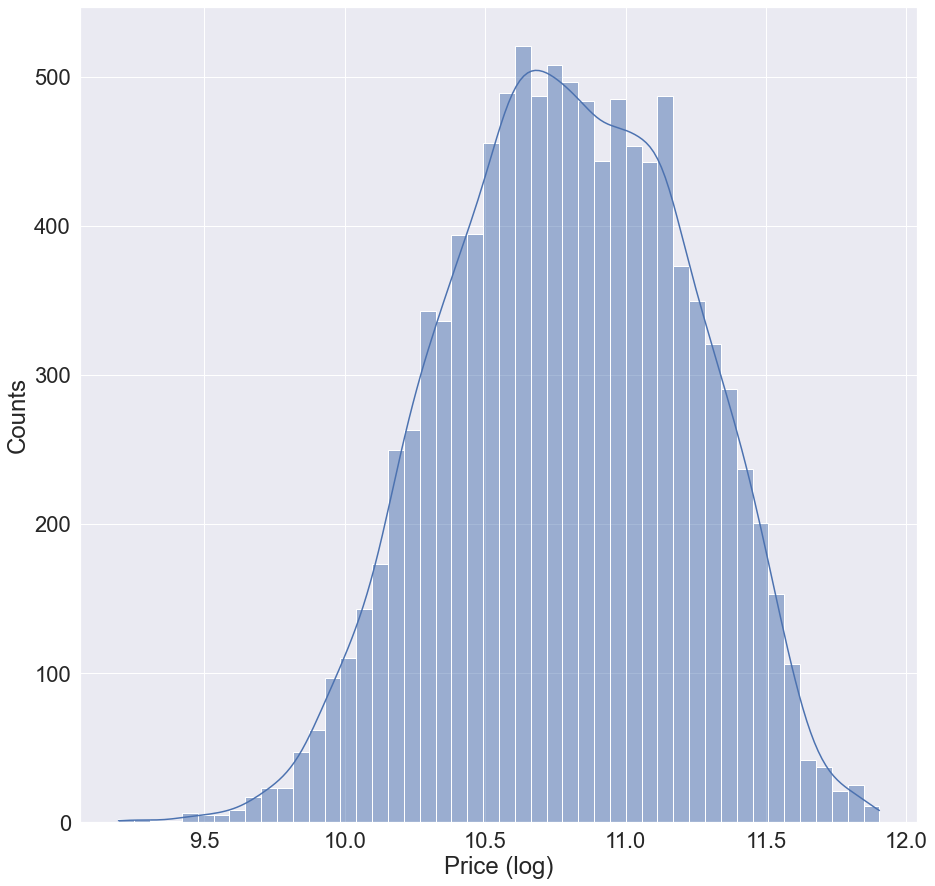

In [12]:
plt.figure(figsize=(15,15))
#plt.hist(df['price'])
sns.histplot(data=df, x='price_log', kde=True)
plt.xlabel('Price (log)')
plt.ylabel('Counts')
#plt.savefig('price_log_hist.png')
plt.show()

In [14]:
df['price_quad'] = np.power(df['price'],2)

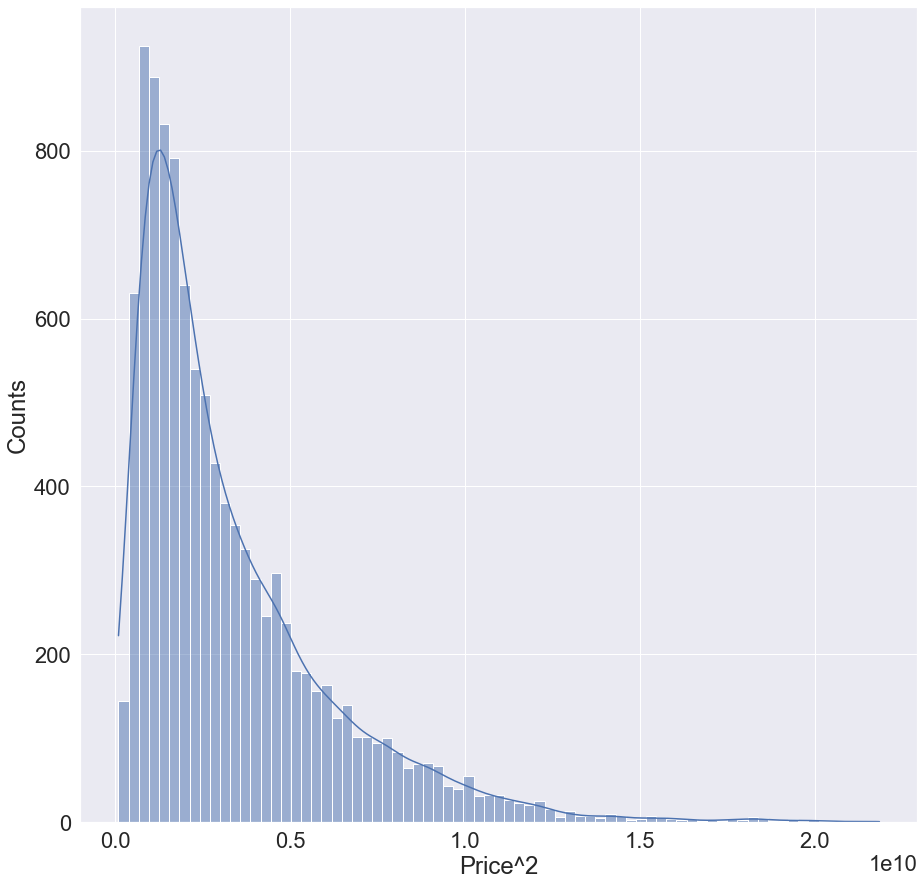

In [15]:
plt.figure(figsize=(15,15))
#plt.hist(df['price'])
sns.histplot(data=df, x='price_quad', kde=True)
plt.xlabel('Price^2')
plt.ylabel('Counts')
#plt.savefig('price_quad_hist.png')
plt.show()

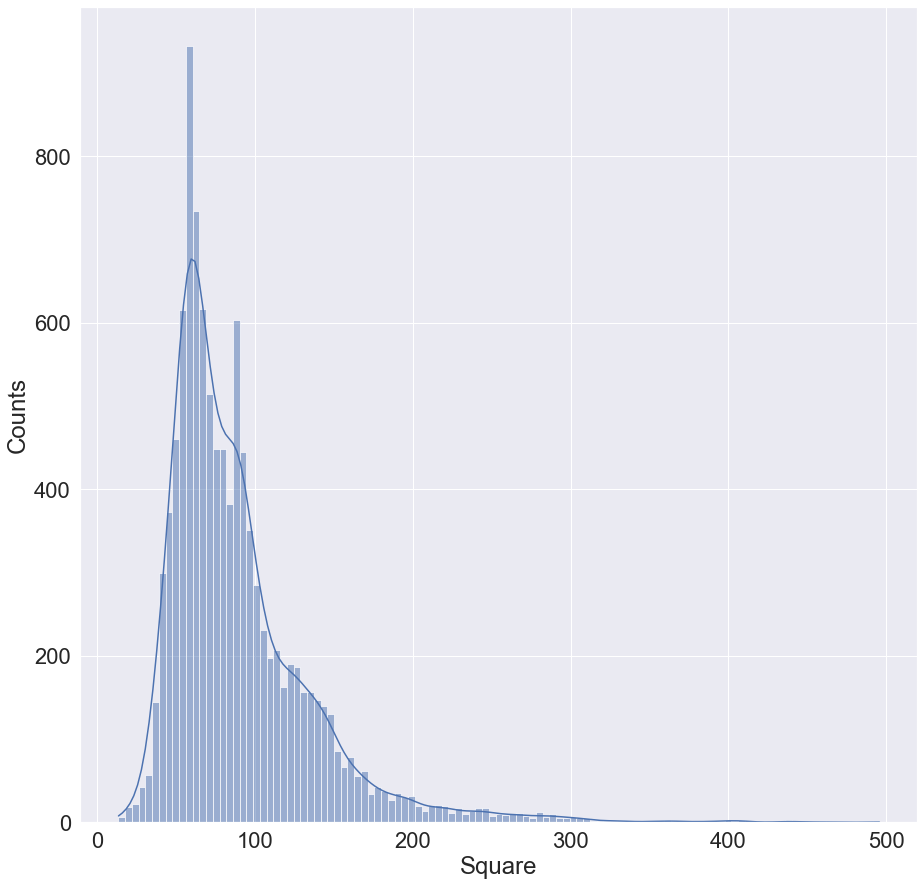

In [16]:
plt.figure(figsize=(15,15))
#plt.hist(df['Lng'])
sns.histplot(data=df, x='square', kde=True)
plt.xlabel('Square')
plt.ylabel('Counts')
#plt.savefig('square_hist.png')
plt.show()

`ladderRatio`: the proportion between number of residents on the same floor and number of elevator of ladder.

In [17]:
df['square_log'] = np.log(df['square'])

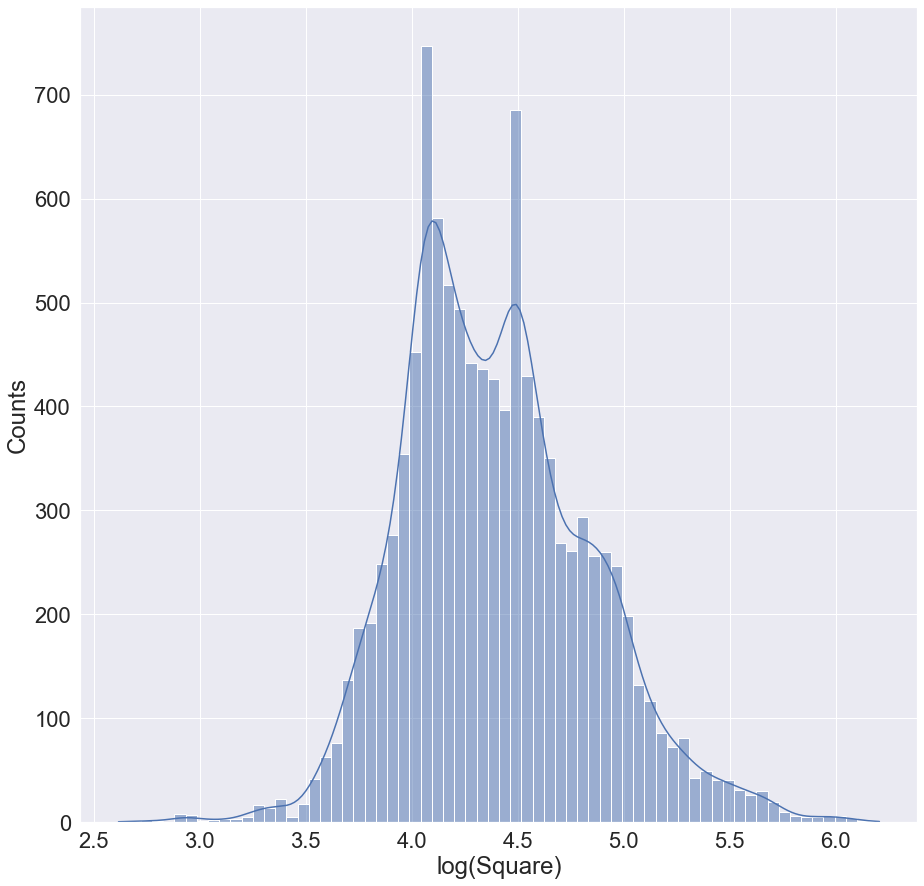

In [18]:
plt.figure(figsize=(15,15))
#plt.hist(df['Lng'])
sns.histplot(data=df, x='square_log', kde=True)
plt.xlabel('log(Square)')
plt.ylabel('Counts')
#plt.savefig('square_log_hist.png')
plt.show()

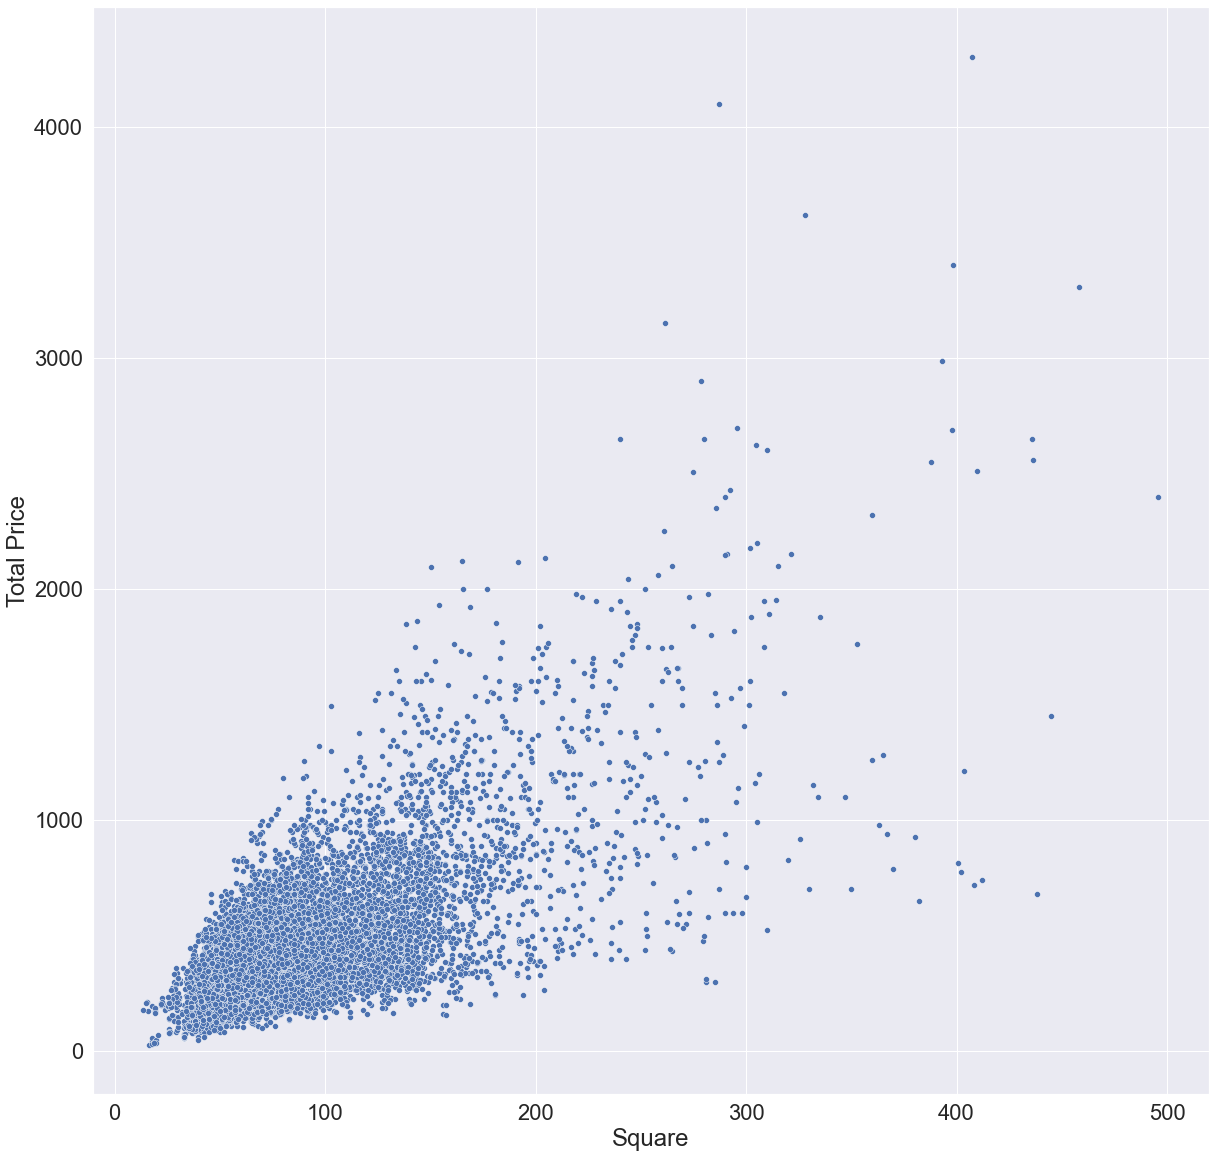

In [22]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=df, x='square', y='totalPrice')
#plt.scatter(df['square'], df['totalPrice'], alpha=0.3)
#plt.scatter(df['square'], df['price'], alpha=0.3)
plt.xlabel('Square')
plt.ylabel('Total Price')
#plt.savefig('square_totalPrice.png')
plt.show()

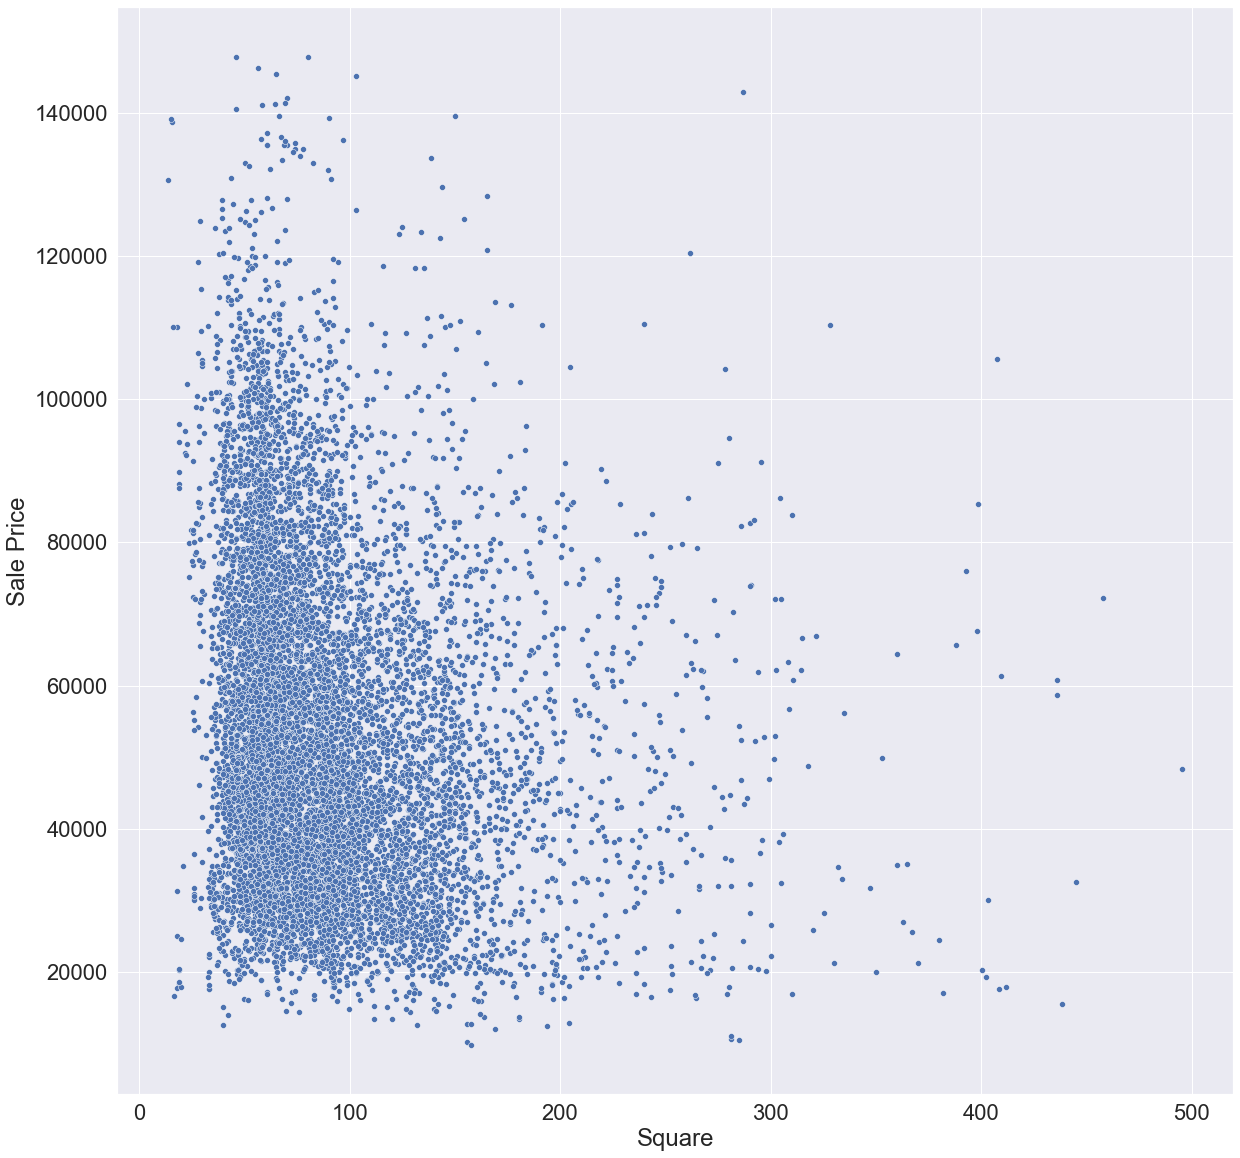

In [23]:
plt.figure(figsize=(20,20))
#plt.scatter(df['square'], df['totalPrice'], alpha=0.3)
#plt.scatter(df['square'], df['price'], alpha=0.3)
sns.scatterplot(data=df, x='square', y='price')
#sns.regplot(data=df, x='square', y='price')
plt.xlabel('Square')
plt.ylabel('Sale Price')
#plt.savefig('square.png')
plt.show()

This was not part of the author's tutorial but I think since these are numerical data it would be useful for us to see correlation from scatter plots. I haven't done too much interpretation with it yet though.

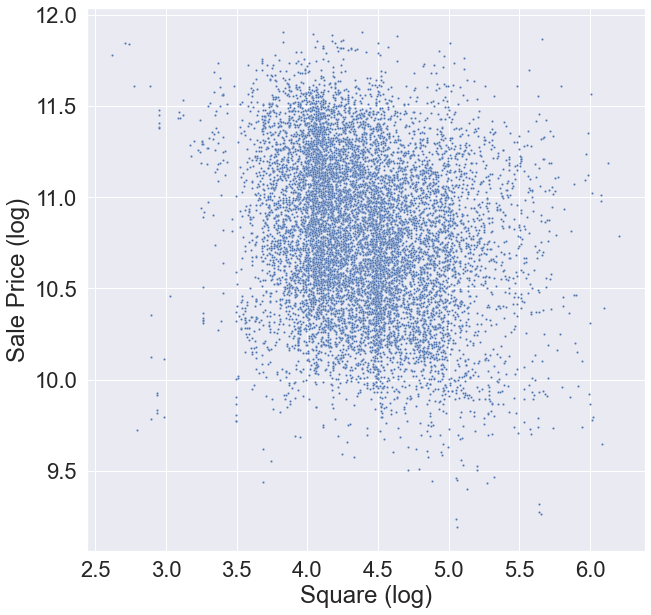

In [24]:
plt.figure(figsize=(10,10))
#plt.scatter(df['square'], df['totalPrice'], alpha=0.3)
#plt.scatter(df['square'], df['price'], alpha=0.3)
sns.scatterplot(data=df, x='square_log', y='price_log', s=5)
#sns.regplot(data=df, x='square', y='price')
plt.xlabel('Square (log)')
plt.ylabel('Sale Price (log)')
#plt.savefig('square.png')
plt.show()

**Also, using `price` probably does make more sense, looking at the `price` and `square` comparison alone, we can see that it is much more interpretable than using `totalPrice`.**

Originally, we see that `totalPrice` is higher when `square` is bigger, which is self-explanatory and doesn't say much about the data. 

But using `price`, we can see that when the `square` is small, the `price` range varies dramatically, probably because smaller houses represent houses closer to the city center, and house price in the city varies a lot. On the other hand, we see that houses with larger squares generally have lower prices overall. 

This reminds me of something! Assuming Temple of Heaven as the city center, using lattitude and longtitude difference probably makes more sense than using the value itself!! 

Temple of Heaven (`39.8822° N, 116.4066° E`)

In [26]:
df['Lng_diff'] = abs(df['Lng']-116.4066)
df['Lat_diff'] = abs(df['Lat']-39.8822)

In [27]:
df['Lng_quad'] = df['Lng']**2
df['Lat_quad'] = df['Lat']**2

In [77]:
df['Lng_diff_quad'] = abs(df['Lng']-116.4066)**2
df['Lat_diff_quad'] = abs(df['Lat']-39.8822)**2

In [96]:
abs(df.corr()[['price']].loc[['Lng_diff', 'Lat_diff', 'Lng_quad', 'Lat_quad', 'Lng_diff_quad', 'Lat_diff_quad', 'Lat', 'Lng']].sort_values('price'))

price
Lng_diff       0.432911
Lng_diff_quad  0.404732
Lat_diff_quad  0.372386
Lat_diff       0.334429
Lat_quad       0.061986
Lat            0.061065
Lng_quad       0.056349
Lng            0.056058

The correlation for location dramatically increased after using the difference! We're on the right track!!!

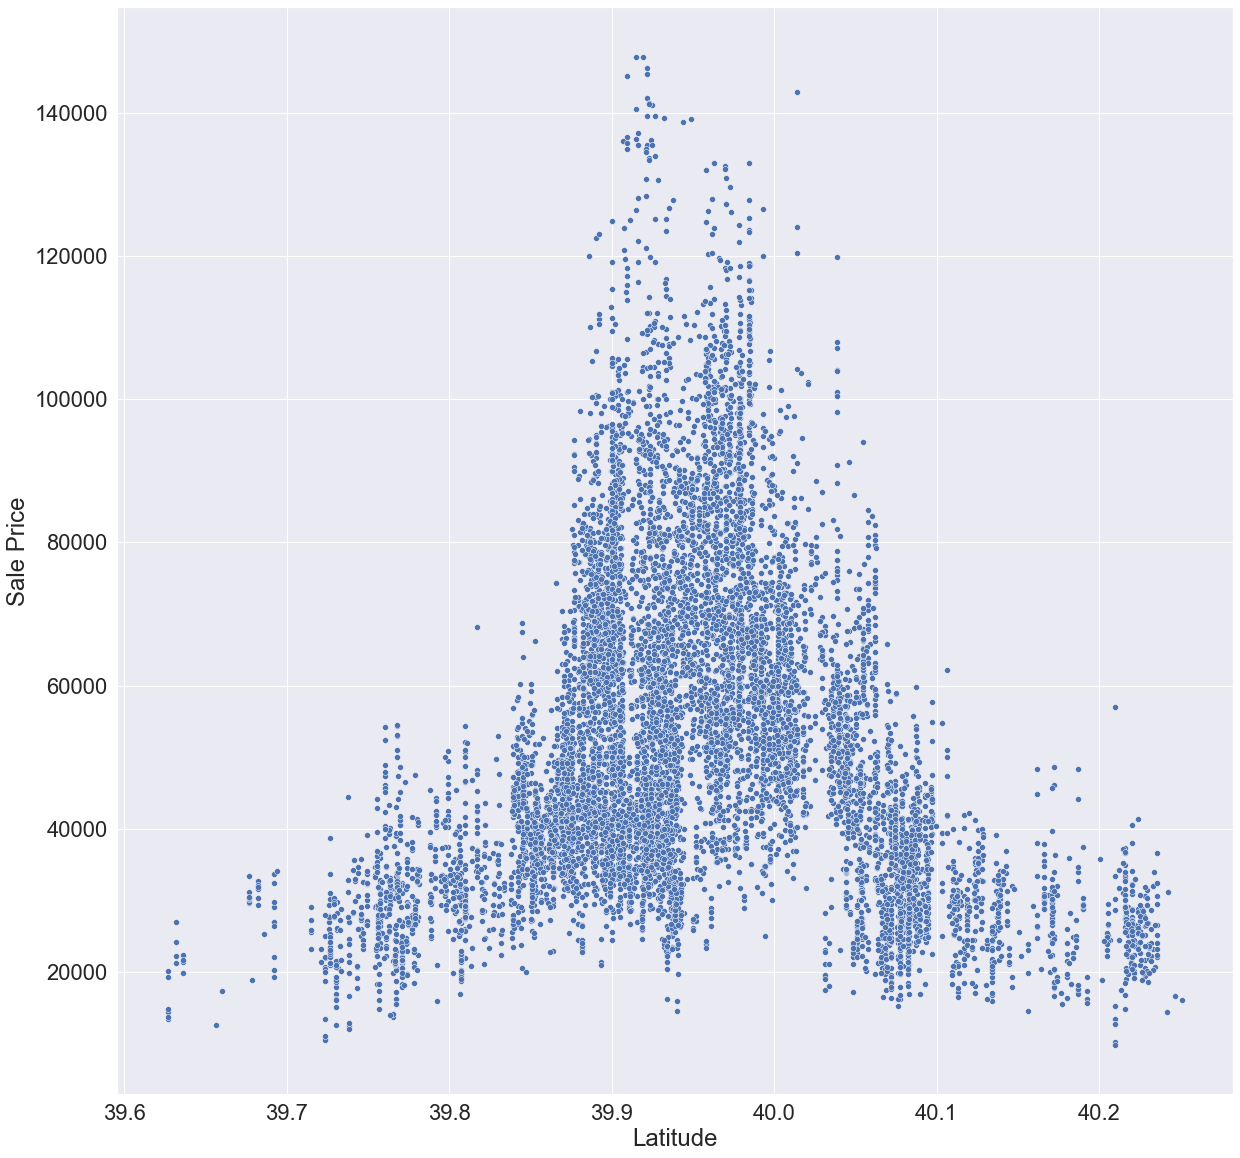

In [19]:
plt.figure(figsize=(20,20))
#plt.scatter(df['Lat'], df['price'], alpha=0.3)
sns.scatterplot(data=df, x='Lat', y='price')
#sns.regplot(data=df, x='Lat', y='price')
#sns.regplot(data=df, x='Lat', y='price', order=3)
plt.xlabel('Latitude')
plt.ylabel('Sale Price')
#plt.savefig('lat.png')
plt.show()

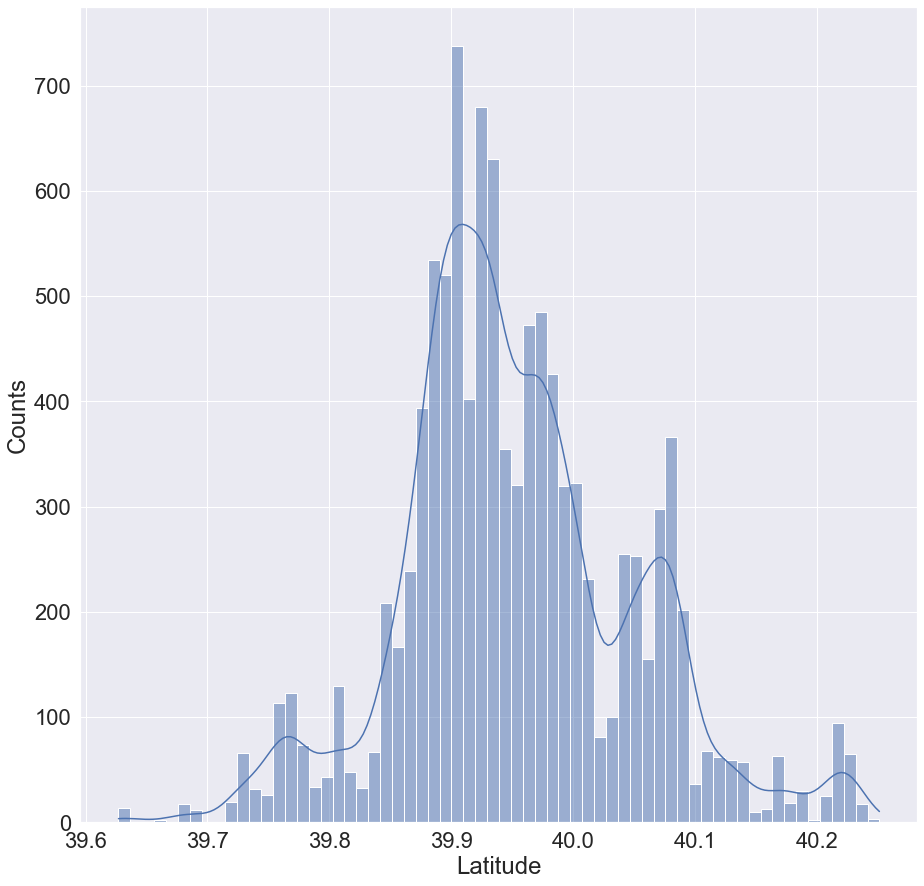

In [26]:
plt.figure(figsize=(15,15))
#plt.hist(df['Lat'])
sns.histplot(data=df, x='Lat', kde=True)
plt.xlabel('Latitude')
plt.ylabel('Counts')
#plt.savefig('lat_hist.png')
plt.show()

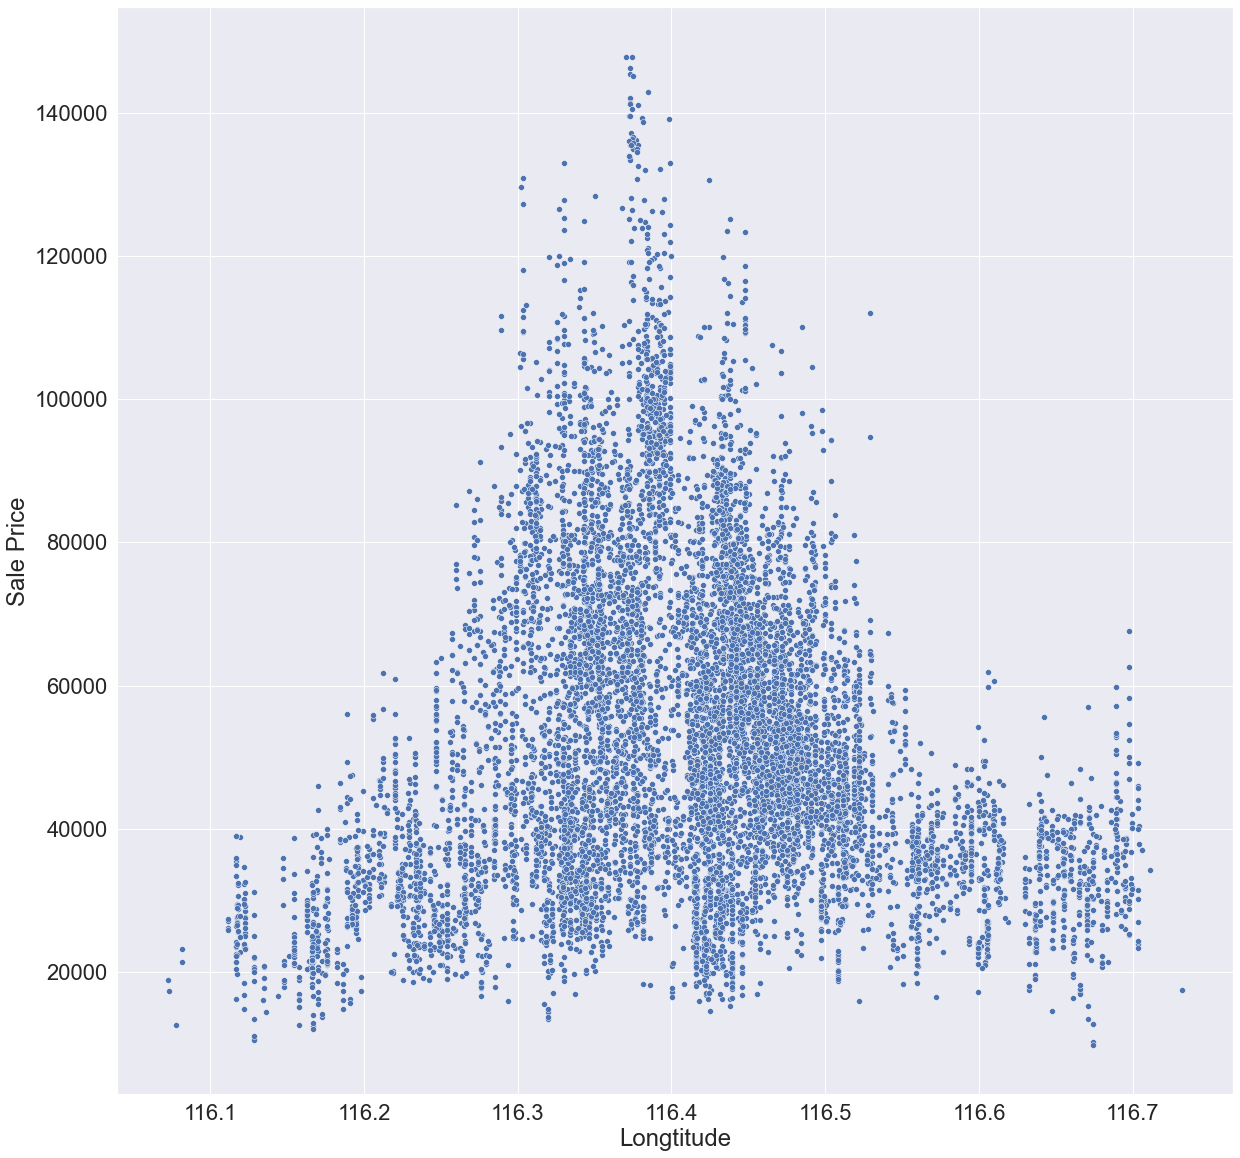

In [20]:
plt.figure(figsize=(20,20))
#plt.scatter(df['Lng'], df['price'], alpha=0.3)
sns.scatterplot(data=df, x='Lng', y='price')
plt.xlabel('Longtitude')
plt.ylabel('Sale Price')
#plt.savefig('lng.png')
plt.show()

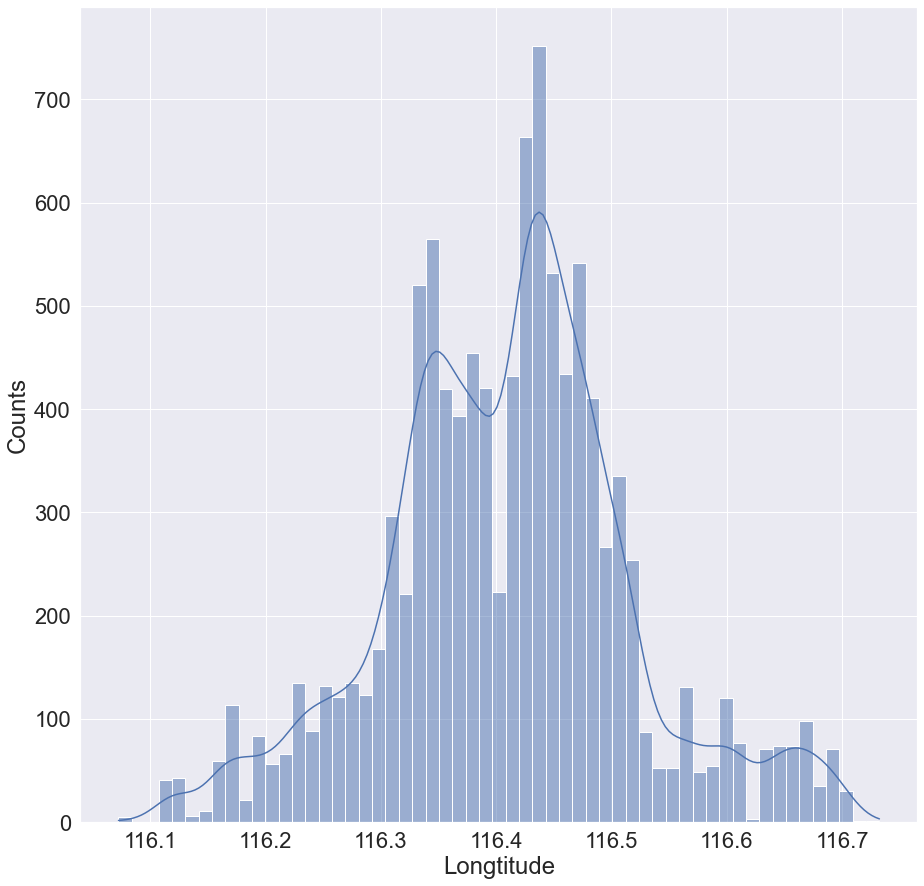

In [27]:
plt.figure(figsize=(15,15))
#plt.hist(df['Lng'])
sns.histplot(data=df, x='Lng', kde=True)
plt.xlabel('Longtitude')
plt.ylabel('Counts')
#plt.savefig('lng_hist.png')
plt.show()

We're definetely on the right track. Latitude and longtitude matter significantly for the price. Prices are higher when closer to city center.

### Step 3: Model Preparation

After finishing exploring the data and engineering features, I want to prepare my data for modeling. 

Here I would drop time series data first because it is slightly more complicated to deal with.

So the data I would be dropping are: `url`, `id`, `Cid` because it is just miscellaneous information, `constructionTime`, `tradeTime` because time-series data is a bit more complicated to deal with, and `buildingStructure`, `renovationCondition` because we already dealt with it in the previous engineering step.

In [63]:
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'price_log', 'price_quad', 'Lng_diff', 'Lat_diff', 'Lng_quad',
       'Lat_quad', 'buildingType1', 'buildingType2', 'buildingType3',
       'buildingType4', 'renovationCondition1', 'renovationCondition2',
       'renovationCondition3', 'renovationCondition4', 'buildingStructure1',
       'buildingStructure2', 'buildingStructure3', 'buildingStructure4',
       'buildingStructure5', 'buildingStructure6', 'constructionTime_diff'],
      dtype='object')

In [89]:
new_df = df[['Lng', 'Lat', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'price_log', 'price_quad', 'Lng_diff', 'Lat_diff', 'Lng_quad',
       'Lat_quad', 'Lng_diff_quad', 'Lat_diff_quad', 'buildingType1', 'buildingType2', 'buildingType3',
       'buildingType4', 'renovationCondition1', 'renovationCondition2',
       'renovationCondition3', 'renovationCondition4', 'buildingStructure1',
       'buildingStructure2', 'buildingStructure3', 'buildingStructure4',
       'buildingStructure5', 'buildingStructure6', 'constructionTime_diff']]
new_df.head(3)

Lng        Lat   DOM  followers  totalPrice  price  square  \
0  116.475489  40.019520  1464        106       415.0  31680  131.00   
1  116.453917  39.881534   903        126       575.0  43436  132.38   
2  116.561978  39.877145  1271         48      1030.0  52021  198.00   

   livingRoom  drawingRoom  kitchen  ...  renovationCondition2  \
0           2            1        1  ...                     0   
1           2            2        1  ...                     0   
2           3            2        1  ...                     0   

   renovationCondition3  renovationCondition4  buildingStructure1  \
0                     1                     0                   0   
1                     0                     1                   0   
2                     1                     0                   0   

   buildingStructure2  buildingStructure3  buildingStructure4  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   

   buildingStructure5  buildingStructure6  constructionTime_diff  
0                   0                   1                   11.0  
1                   0                   1                   12.0  
2                   0                   1                   11.0  

[3 rows x 42 columns]

In [90]:
pd.get_dummies(new_df)

Lng        Lat   DOM  followers  totalPrice  price  square  \
0      116.475489  40.019520  1464        106       415.0  31680  131.00   
1      116.453917  39.881534   903        126       575.0  43436  132.38   
2      116.561978  39.877145  1271         48      1030.0  52021  198.00   
3      116.438010  40.076114   965        138       297.5  22202  134.00   
4      116.428392  39.886229   927        286       392.0  48396   81.00   
...           ...        ...   ...        ...         ...    ...     ...   
10624  116.478366  39.941392   139         52      1160.0  50922  227.80   
10625  116.370937  39.889555    96         12       448.0  61888   72.39   
10626  116.442298  39.970551    23         93       218.0  53171   41.00   
10627  116.425063  40.044097    84          7       178.0  31168   57.11   
10628  116.364028  39.870465    23          2       278.0  47808   58.15   

       livingRoom  drawingRoom  kitchen  ...  renovationCondition2  \
0               2            1        1  ...                     0   
1               2            2        1  ...                     0   
2               3            2        1  ...                     0   
3               3            1        1  ...                     0   
4               2            1        1  ...                     1   
...           ...          ...      ...  ...                   ...   
10624           3            2        1  ...                     0   
10625           1            1        1  ...                     0   
10626           1            1        1  ...                     0   
10627           1            1        1  ...                     0   
10628           2            1        1  ...                     0   

       renovationCondition3  renovationCondition4  buildingStructure1  \
0                         1                     0                   0   
1                         0                     1                   0   
2                         1                     0                   0   
3                         0                     0                   0   
4                         0                     0                   0   
...                     ...                   ...                 ...   
10624                     0                     1                   0   
10625                     1                     0                   0   
10626                     1                     0                   0   
10627                     0                     1                   0   
10628                     1                     0                   0   

       buildingStructure2  buildingStructure3  buildingStructure4  \
0                       0                   0                   0   
1                       0                   0                   0   
2                       0                   0                   0   
3                       0                   0                   0   
4                       1                   0                   0   
...                   ...                 ...                 ...   
10624                   0                   0                   0   
10625                   0                   0                   0   
10626                   0                   0                   0   
10627                   0                   0                   0   
10628                   1                   0                   0   

       buildingStructure5  buildingStructure6  constructionTime_diff  
0                       0                   1                   11.0  
1                       0                   1                   12.0  
2                       0                   1                   11.0  
3                       0                   1                    8.0  
4                       0                   0                   56.0  
...                   ...                 ...                    ...  
10624                   0                   1            

After dealing with the data and dropping the columns we don't need, can't deal with, or already dealt with, we can see that no more additional categorical variables of interest needs to be dummified, and the columns before and after dummifying remains the same.

In [91]:
id_df = df[['url', 'id', 'Cid', 'tradeTime']]

In [92]:
dummies_df = pd.concat([id_df, new_df], axis=1, sort=False)

In [93]:
#dummies_df.to_csv('dummies_data.csv')

In [76]:
dummies_df.columns

Index(['url', 'id', 'Cid', 'tradeTime', 'Lng', 'Lat', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'price_log', 'price_quad', 'Lng_diff', 'Lat_diff', 'Lng_quad',
       'Lat_quad', 'buildingType1', 'buildingType2', 'buildingType3',
       'buildingType4', 'renovationCondition1', 'renovationCondition2',
       'renovationCondition3', 'renovationCondition4', 'buildingStructure1',
       'buildingStructure2', 'buildingStructure3', 'buildingStructure4',
       'buildingStructure5', 'buildingStructure6', 'constructionTime_diff'],
      dtype='object')

### replot correlation matrix!

In [100]:
selected_cols = ['price_log', 'square',
 'Lng_diff_quad', 'Lat_diff_quad',
 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'constructionTime', 
 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway',
 'buildingType1', 'buildingType2', 'buildingType3', 'buildingType4', 
 'renovationCondition1', 'renovationCondition2', 'renovationCondition3', 'renovationCondition4', 
 'buildingStructure1', 'buildingStructure2', 'buildingStructure3', 'buildingStructure4', 'buildingStructure5', 'buildingStructure6']

In [205]:
selected_df = dummies_df[selected_cols]

In [102]:
selected_corr_matrix = selected_df.corr()[selected_cols]

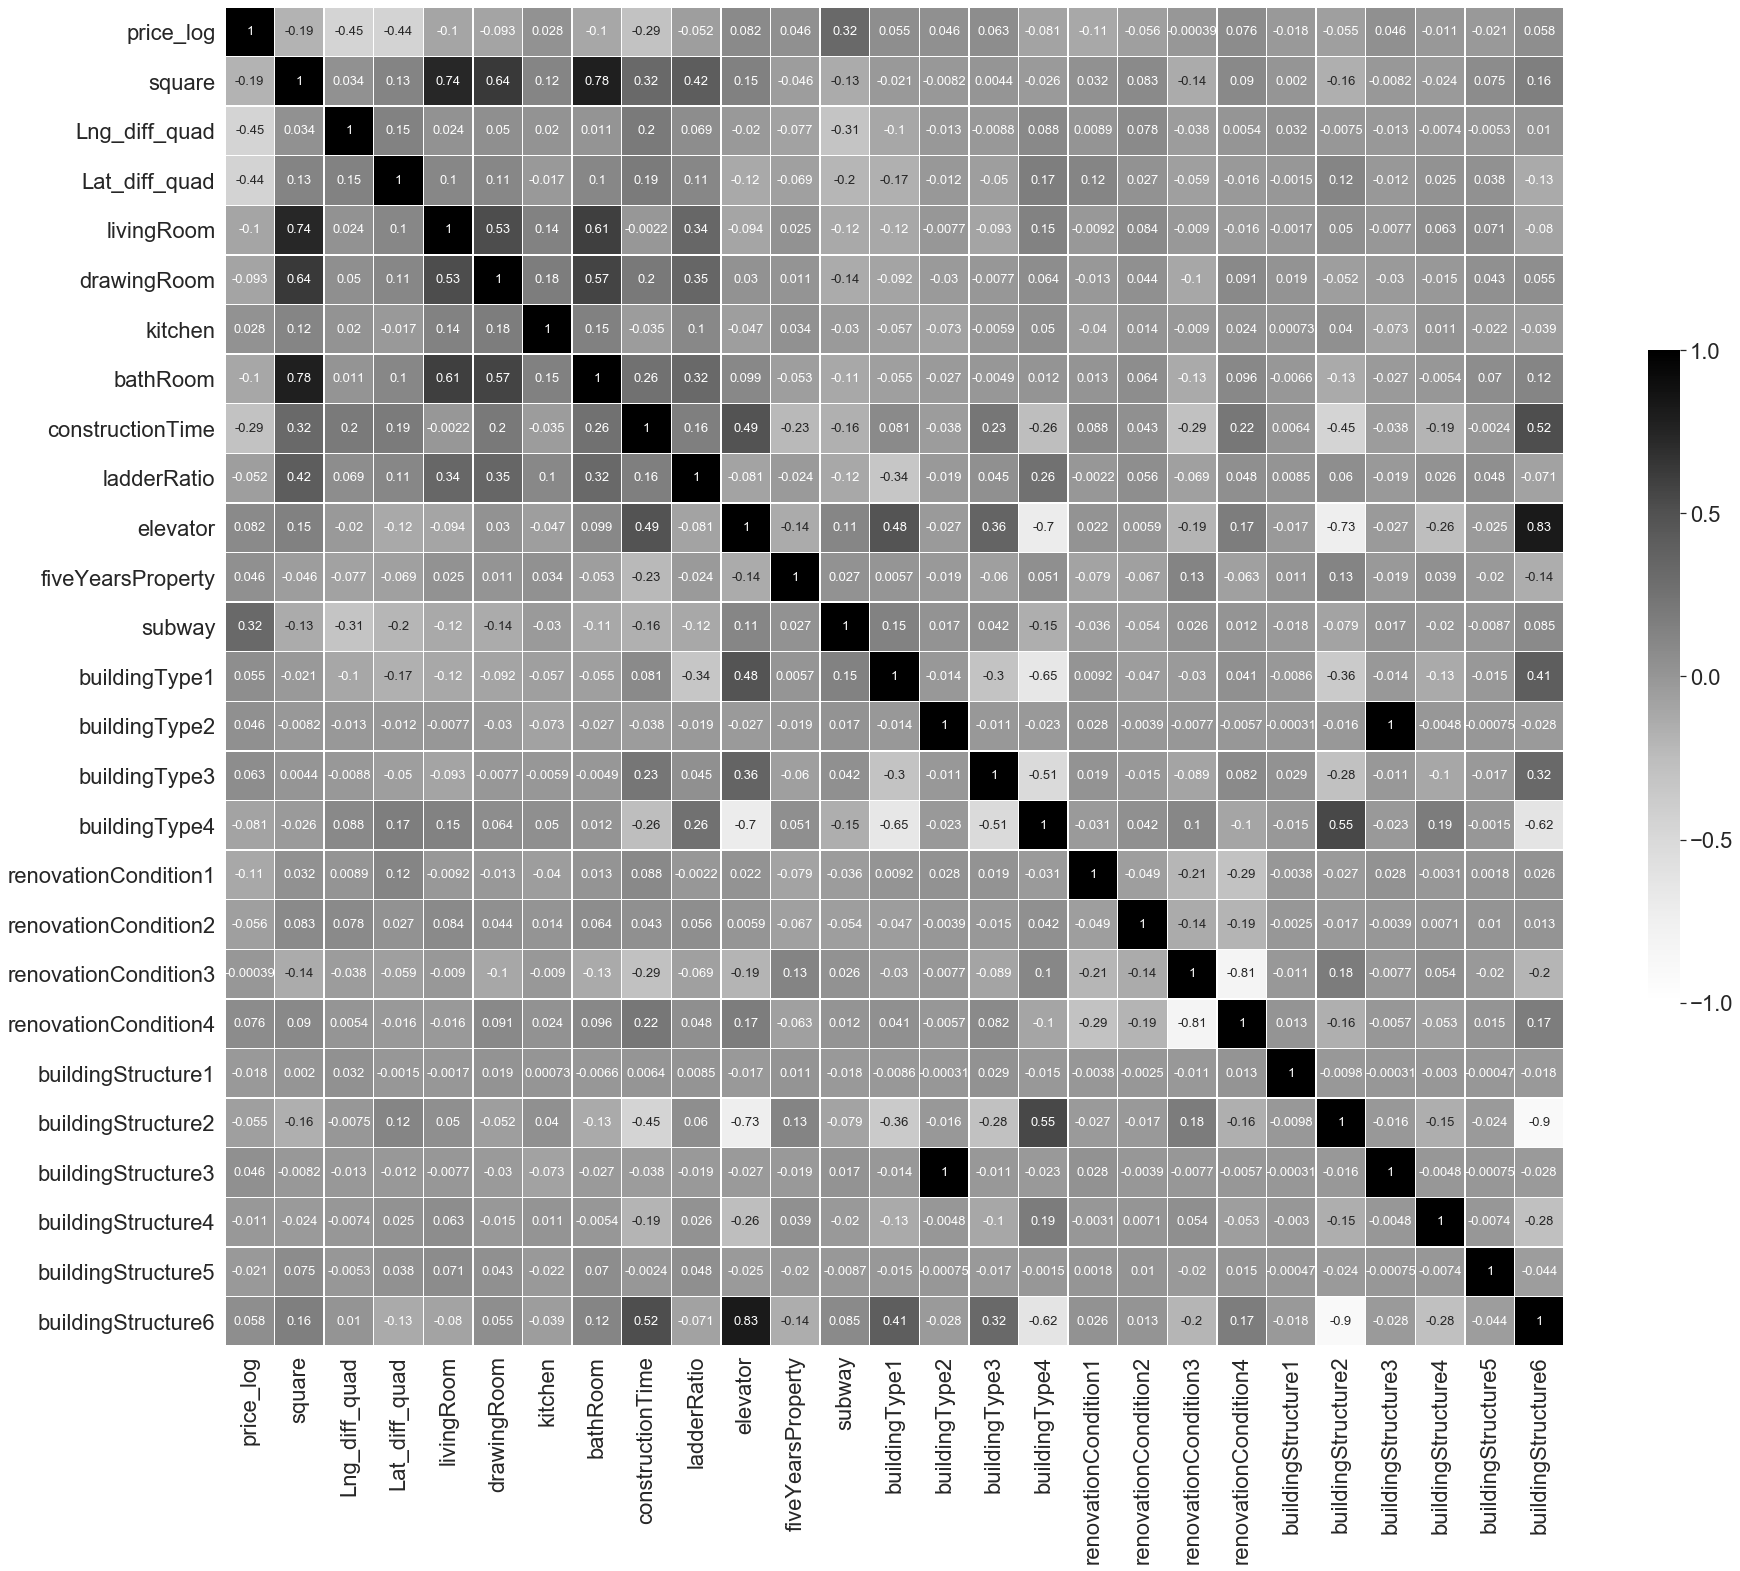

In [308]:
f, ax = plt.subplots(figsize=(30, 30))

heatmap = sns.heatmap(selected_corr_matrix,
                      square = True,
                      linewidths = .5,
                      #cmap = 'coolwarm',
                      cmap = 'Greys',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                                #'ticks' : [0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 13})

#add the column names as labels
ax.set_yticklabels(selected_cols, rotation = 0)
ax.set_xticklabels(selected_cols)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
sns.set(font_scale=2)

#f.savefig('selected_corr_matrix_mono.png')

In [240]:
df.dropna(subset=['constructionTime'], inplace=True)

In [242]:
df['constructionTime'] = df[df['constructionTime']!='????']['constructionTime'].astype('int64')

In [249]:
df.dropna(subset=['constructionTime'], inplace=True)

In [250]:
df.describe()['constructionTime']

count    10331.000000
mean      1999.886265
std          8.971944
min       1944.000000
25%       1994.000000
50%       2002.000000
75%       2006.000000
max       2016.000000
Name: constructionTime, dtype: float64

In [251]:
stats.describe(df['constructionTime'])

DescribeResult(nobs=10331, minmax=(1944.0, 2016.0), mean=1999.8862646404027, variance=80.49577550362758, skewness=-0.9168742586243968, kurtosis=0.952317840360434)

In [306]:
selected_df.describe()['buildingType3']

count    10331.000000
mean         0.189720
std          0.392099
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: buildingType3, dtype: float64

In [281]:
stats.describe(df['price'])

DescribeResult(nobs=10331, minmax=(9841, 147797), mean=53082.72432484755, variance=499085555.311992, skewness=0.8134901228808842, kurtosis=0.3637550558495062)

In [304]:
selected_df.columns

Index(['price_log', 'square', 'Lng_diff_quad', 'Lat_diff_quad', 'livingRoom',
       'drawingRoom', 'kitchen', 'bathRoom', 'constructionTime', 'ladderRatio',
       'elevator', 'fiveYearsProperty', 'subway', 'buildingType1',
       'buildingType2', 'buildingType3', 'buildingType4',
       'renovationCondition1', 'renovationCondition2', 'renovationCondition3',
       'renovationCondition4', 'buildingStructure1', 'buildingStructure2',
       'buildingStructure3', 'buildingStructure4', 'buildingStructure5',
       'buildingStructure6'],
      dtype='object')

In [228]:
#stats.describe(selected_df)

In [229]:
print('kurtosis')
cols = selected_df.columns
kurtosis = [-4.51383466e-01,  7.61729106e+00,  5.07825589e+00,  8.51319542e+00,
        2.24177089e+00,  1.04472077e+00,  6.73897014e+01,  7.96623650e+00,
                   'nan',  9.69760308e+00, -1.81484017e+00, -1.76471408e+00,
       -1.73896942e+00, -1.02420119e+00,  2.06120048e+03,  5.05060047e-01,
       -1.99194973e+00,  9.38400216e+00,  2.76215610e+01, -1.70931436e+00,
       -1.98595960e+00,  5.16050019e+03, -1.49299822e+00,  2.06120048e+03,
        1.71222364e+01,  8.55917830e+02, -1.75309174e+00]
for i in range(len(cols)):
    print(f'{cols[i]}: {kurtosis[i]}')

kurtosis
price_log: -0.451383466
square: 7.61729106
Lng_diff_quad: 5.07825589
Lat_diff_quad: 8.51319542
livingRoom: 2.24177089
drawingRoom: 1.04472077
kitchen: 67.3897014
bathRoom: 7.9662365
constructionTime: nan
ladderRatio: 9.69760308
elevator: -1.81484017
fiveYearsProperty: -1.76471408
subway: -1.73896942
buildingType1: -1.02420119
buildingType2: 2061.20048
buildingType3: 0.505060047
buildingType4: -1.99194973
renovationCondition1: 9.38400216
renovationCondition2: 27.621561
renovationCondition3: -1.70931436
renovationCondition4: -1.9859596
buildingStructure1: 5160.50019
buildingStructure2: -1.49299822
buildingStructure3: 2061.20048
buildingStructure4: 17.1222364
buildingStructure5: 855.91783
buildingStructure6: -1.75309174


In [225]:
print('skewness')
cols = selected_df.columns
skewness = [-0.11224799,  2.1751184 ,  2.34523206,  2.69114424,  0.86205937,
        0.36727098, -3.54579632,  2.35664172,         'nan',  2.07465202,
       -0.43030202, -0.4850628 , -0.51091152,  0.9878253 , 45.42246673,
        1.58273815, -0.08972329,  3.3740187 ,  5.44256934,  0.53915271,
       -0.11849219, 71.85054066,  0.71204057, 45.42246673,  4.37289794,
       29.29023437, -0.49689864]
for i in range(len(cols)):
    print(f'{cols[i]}: {skewness[i]}')

skewness
price_log: -0.11224799
square: 2.1751184
Lng_diff_quad: 2.34523206
Lat_diff_quad: 2.69114424
livingRoom: 0.86205937
drawingRoom: 0.36727098
kitchen: -3.54579632
bathRoom: 2.35664172
constructionTime: nan
ladderRatio: 2.07465202
elevator: -0.43030202
fiveYearsProperty: -0.4850628
subway: -0.51091152
buildingType1: 0.9878253
buildingType2: 45.42246673
buildingType3: 1.58273815
buildingType4: -0.08972329
renovationCondition1: 3.3740187
renovationCondition2: 5.44256934
renovationCondition3: 0.53915271
renovationCondition4: -0.11849219
buildingStructure1: 71.85054066
buildingStructure2: 0.71204057
buildingStructure3: 45.42246673
buildingStructure4: 4.37289794
buildingStructure5: 29.29023437
buildingStructure6: -0.49689864


### plot maps!!

In [117]:
street_map = gpd.read_file('Beijing-shp/shape/roads.shp')

In [119]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df['Lng'], df['Lat'])]
geo_df = gpd.GeoDataFrame(selected_df, crs=crs, geometry=geometry)

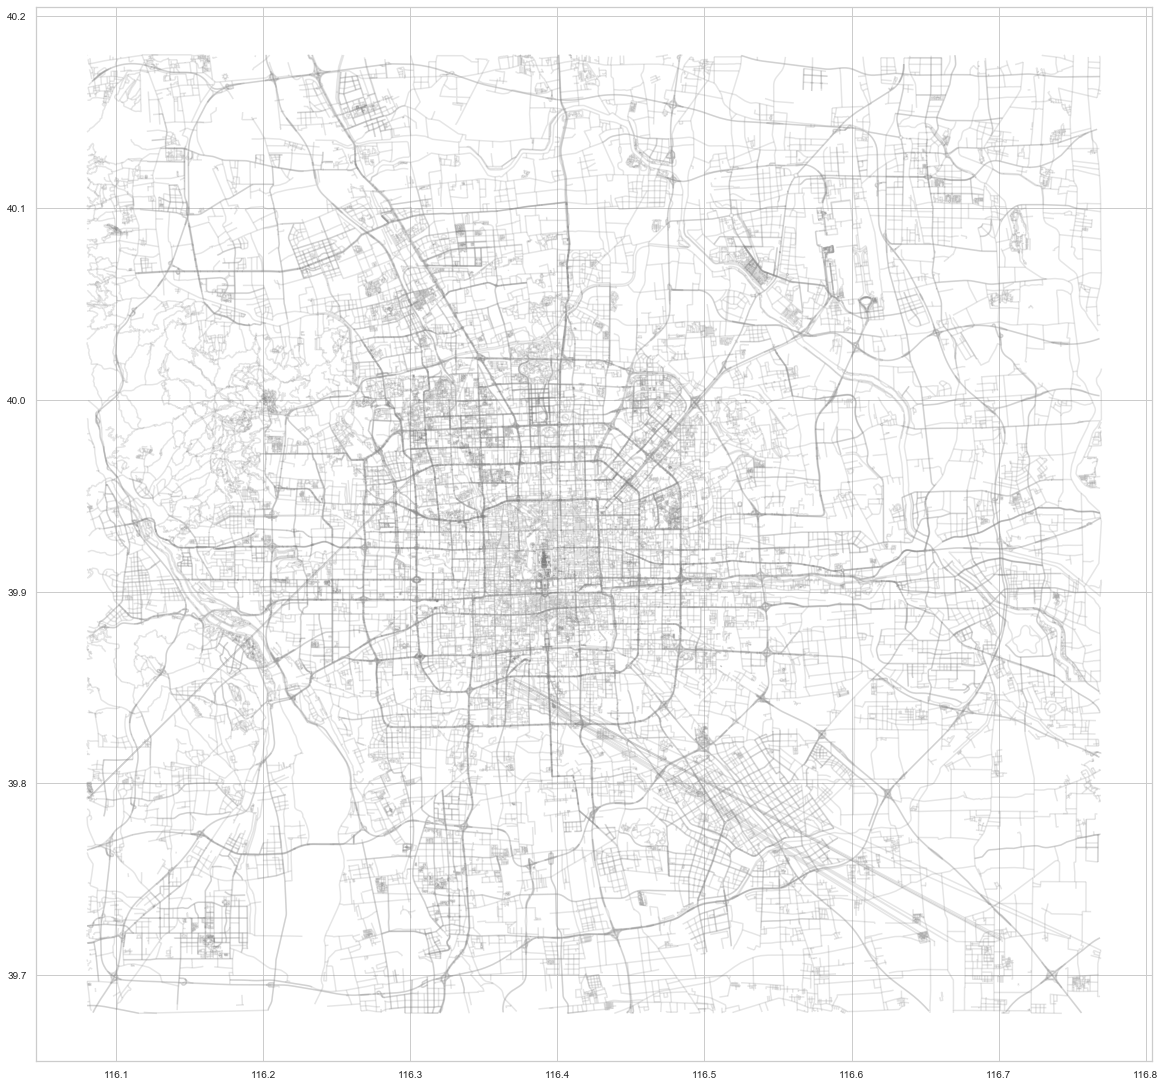

In [312]:
fig,ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax, alpha=0.2, color='grey')
#geo_df[geo_df['price_log']>=avg].plot(ax=ax, color='black', label='high price', alpha=0.5)
#geo_df[geo_df['price_log']<avg].plot(ax=ax, color='grey', label='low price', alpha=0.5)
#plt.legend()
#plt.title('House Price Per Square Distribution Across Beijing')
#plt.show()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.savefig('BJ.png')

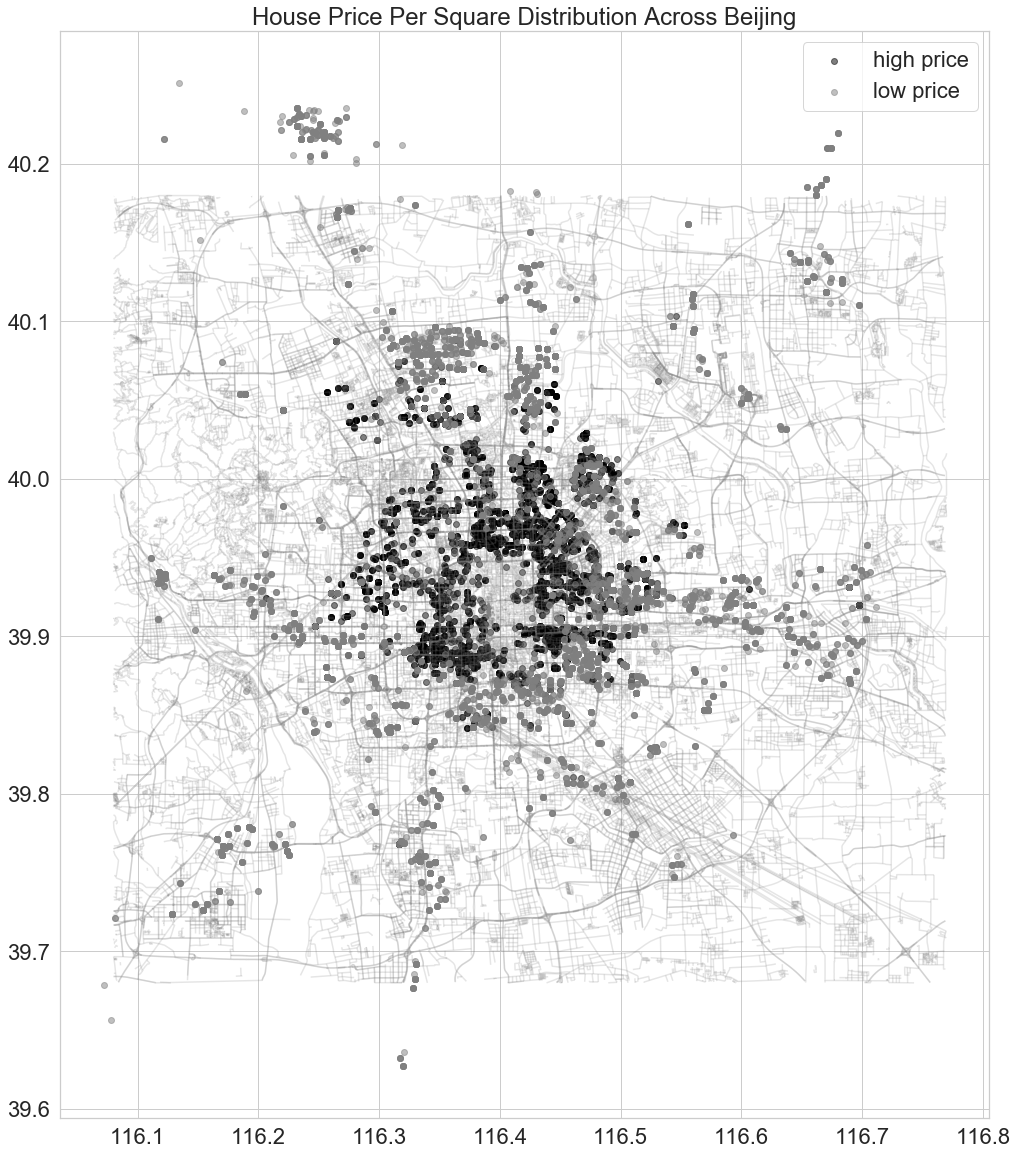

<Figure size 432x288 with 0 Axes>

In [129]:
avg = geo_df['price_log'].mean()
fig,ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax, alpha=0.2, color='grey')
geo_df[geo_df['price_log']>=avg].plot(ax=ax, color='black', label='high price', alpha=0.5)
geo_df[geo_df['price_log']<avg].plot(ax=ax, color='grey', label='low price', alpha=0.5)
plt.legend()
plt.title('House Price Per Square Distribution Across Beijing')
plt.show()
#fig.savefig('price_map_mono.png')

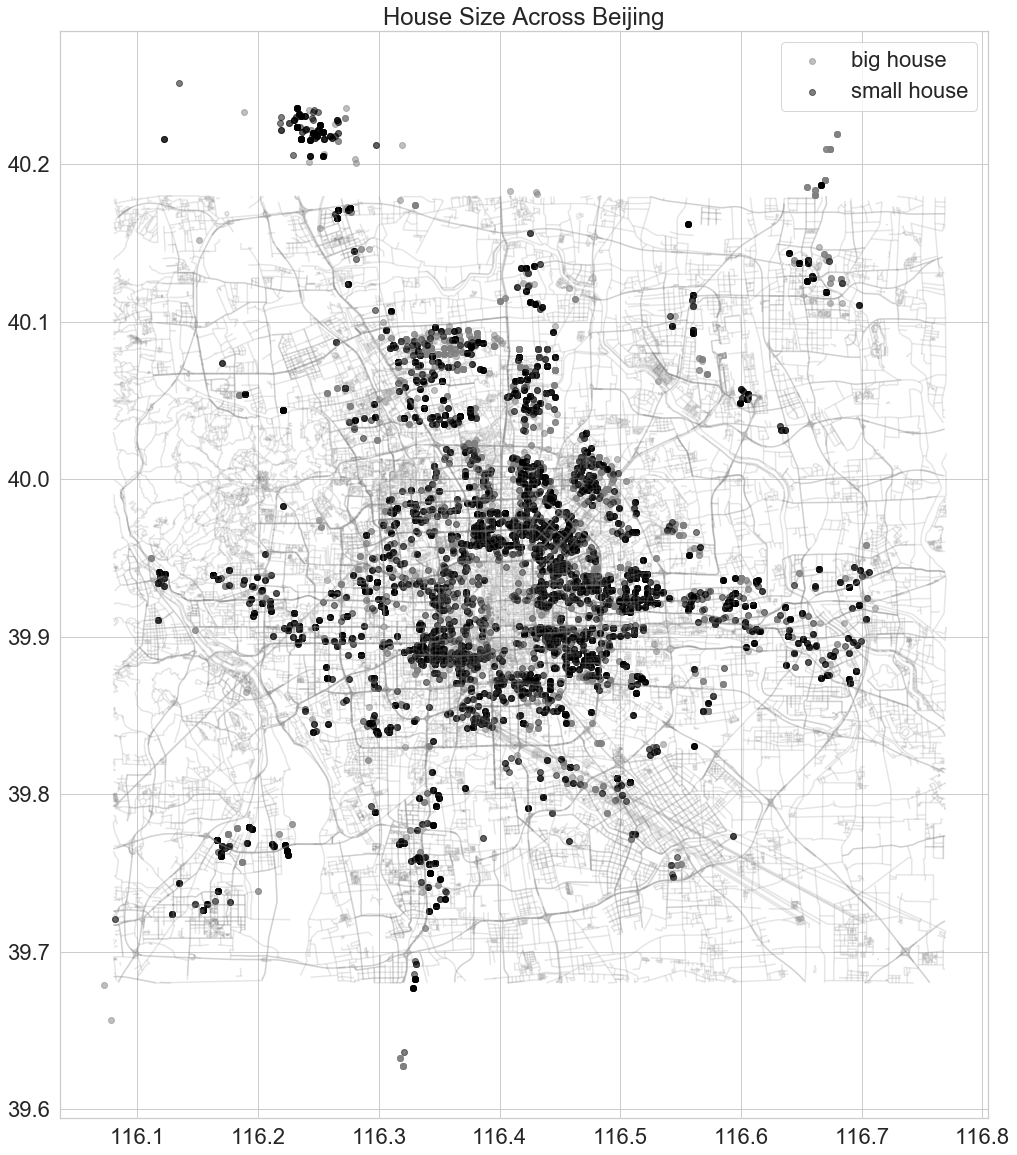

In [147]:
avg = geo_df['square'].mean()
fig,ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax, alpha=0.2, color='grey')
geo_df[geo_df['square']>=avg].plot(ax=ax, color='grey', label='big house', alpha=0.5)
geo_df[geo_df['square']<avg].plot(ax=ax, color='black', label='small house', alpha=0.5)
plt.legend()
plt.title('House Size Across Beijing')
plt.show()
#fig.savefig('square_map_mono.png')

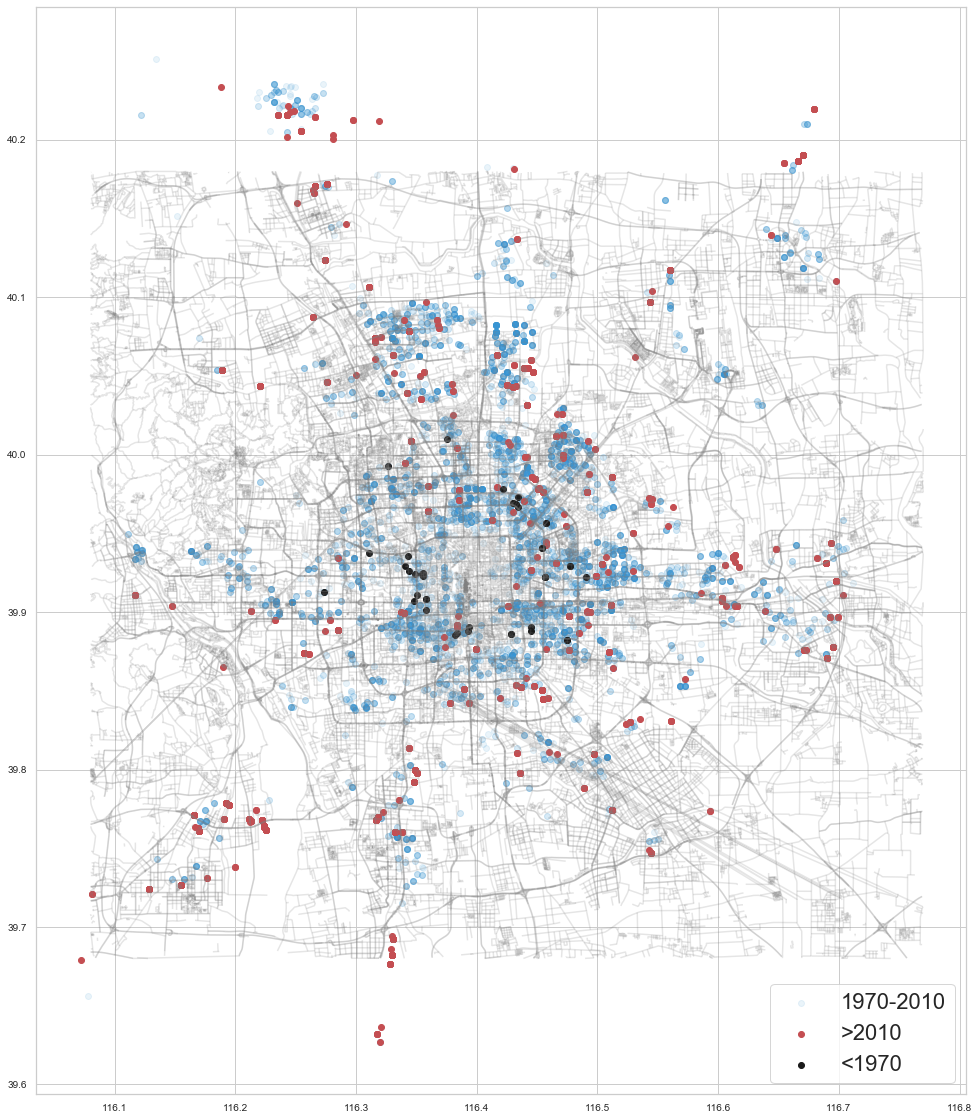

In [329]:
fig,ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax, alpha=0.2, color='grey')
geo_df[(geo_df['constructionTime']>=1970) & (geo_df['constructionTime']<2010)].plot(
    ax=ax, color='#3895d3', label='1970-2010', alpha=0.1)
geo_df[geo_df['constructionTime']>=2010].plot(ax=ax, color='r', label='>2010', alpha=1)
geo_df[geo_df['constructionTime']<1970].plot(ax=ax, color='k', label='<1970', alpha=1)
plt.legend()
#plt.title('House Age Across Beijing')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
#fig.savefig('constructionTime_colored.png')

Next, we split data into training and testing sets using `train_test_split()` as the original author suggests. *Alternatively, we could also use `StratifiedShuffleSplit` which is a more robust method with cross-validation.*

In [ ]:
new_df.columns

In [ ]:
# before engineered original; drop buildingType
X_full = df[['Lng', 'Lat', 'DOM', 'followers', 'price', 'square',
       'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom',
       'renovationCondition', 'buildingStructure',  'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway']]

In [ ]:
y = df['totalPrice']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.33, random_state=42)

In [ ]:
corr_matrix = new_df.corr()[['totalPrice']].sort_values('totalPrice')
corr_target = abs(corr_matrix)
corr_target.sort_values('totalPrice', ascending=False)

I noticed that `renovationCondition1/2` have higher correlation than original, which means that engineering the features were helpful. However, `buildingType` and `bulidingStructure` seem to have got lower :(

In [ ]:
# correlation > 0.5
X1 = df[['price', 'square', 'livingRoom', 'bathRoom']]

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.33, random_state=42)

I don't know if I should drop `price` and `square` because they are directly related to `totalPrice`. But then we only have two variables with correlation higher than 0.5.

In [ ]:
# correlation > 0.5; drop price
X11 = df[['square', 'livingRoom', 'bathRoom']]
X_train11, X_test11, y_train11, y_test11 = train_test_split(X11, y, test_size=0.33, random_state=42)

In [ ]:
# correlation > 0.5; drop square
X12 = df[['price', 'livingRoom', 'bathRoom']]
X_train12, X_test12, y_train12, y_test12 = train_test_split(X12, y, test_size=0.33, random_state=42)

In [ ]:
# correlation > 0.5; drop price and square
X13 = df[['livingRoom', 'bathRoom']]
X_train13, X_test13, y_train13, y_test13 = train_test_split(X13, y, test_size=0.33, random_state=42)

In [ ]:
# correlation > 0.3
X2 = df[['price', 'square', 'livingRoom', 'bathRoom', 'drawingRoom', 'ladderRatio']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.33, random_state=42)

In [ ]:
# correlation > 0.3 and engineered
X3 = df[['Lng', 'Lat', 'DOM', 'followers', 'price', 'square',
       'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom',
       'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 
       'buildingType1', 'buildingType2',
       'renovationCondition1', 'renovationCondition2', 
       'buildingStructure1', 'buildingStructure2']]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.33, random_state=42)

### Step 4: Modeling

Modeling is an iterative process in which several models were built in order to inform my final model. In total, the author built six models. All models were evaluated using the R2 score.

In [ ]:
def display_R2_scores(model, X_train, y_train, X_test, y_test):
    print(f'The mean cross validation score for this model is {round(cross_val_score(model, X_train, y_train).mean(),4)}.')
    print(f'The training score for this model is {round(model.score(X_train, y_train), 4)}.')
    print(f'The testing score for this model is {round(model.score(X_test, y_test),4)}.')

#### Model 1: 
This model was a linear regression model using features identified to be important during EDA.

`['price', 'square', 'livingRoom', 'bathRoom']`

In [ ]:
lr = LinearRegression()
lr.fit(X_train1, y_train1)

In [ ]:
display_R2_scores(lr, X_train1, y_train1, X_test1, y_test1)

`['square', 'livingRoom', 'bathRoom']`

In [ ]:
lr = LinearRegression()
lr.fit(X_train11, y_train11)
display_R2_scores(lr, X_train11, y_train11, X_test11, y_test11)

`['price', 'livingRoom', 'bathRoom']`

In [ ]:
lr = LinearRegression()
lr.fit(X_train12, y_train12)
display_R2_scores(lr, X_train12, y_train12, X_test12, y_test12)

`['livingRoom', 'bathRoom']`

In [ ]:
lr = LinearRegression()
lr.fit(X_train13, y_train13)
display_R2_scores(lr, X_train13, y_train13, X_test13, y_test13)

Seems that `price` and `square` still needs to be kept.

#### Model 2: 
*The final model was a linear regression with features identified to be important during EDA and the LASSO regression. Because the target was not normally distributed, for this model, it was log-transformed.*

Our final model is putting everything in and not engineering it???

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
display_R2_scores(lr, X_train, y_train, X_test, y_test)

### Step 6: Model Evaluation

In [ ]:
lr.coef_

In [ ]:
lr.intercept_

In [ ]:
y_hat = lr.predict(X_test)

In [ ]:
# only plotting test data here or else it would be really filled
plt.figure(figsize=(20,20))
plt.scatter(y_test, y_hat, alpha=0.3, s=50, label='house price')
plt.plot([-200,2600], [-200,2600], c='r', linewidth=3, label='boundary')
plt.xlabel('Actual Price (y)')
plt.ylabel('Predicted Price (y_hat)')
plt.title('Comparison of Actual Price to Predicted Price')
plt.legend()
plt.show()
plt.savefig('predicted_truth_compare.png')